## Exploration Ensemble Models - v2
- Create and train differents ensemble models (using SKLEARN)
- Evaluating then using the distribution of metrics using repeated cross validation (see previos notebook exploration evaluation models)
- EXTRA: get the best 2 models train with all train dataframe and evaluate it with test dataframe

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import xgboost
import lightgbm as ltb
from sklearn import datasets, linear_model

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score


from sklearn.ensemble import StackingRegressor


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import warnings
warnings.filterwarnings("ignore")

In [2]:
### LOAD AUXILIAR FUNCTIONS NOTEBOOK 1

# auxiliar functions
def evaluate_metrics(model, X, y_true):
    '''
    Evaluate rmse, mae, mean of rmse+mae.
    
    OBS: 
     - Inside the functions is called the method model.predict()
     - Calculate the metrics (using y_true vs y_predict) and save it in a dataframe
    '''
    # predict
    prediction = model.predict(X)
    
    # create a dataframe where the metrics are saved
    df_metrics = pd.DataFrame([], columns = ['metric_value'])
    
    
    #### rmse ####
    # calculate
    rmse = mean_squared_error(y_true = y_true,
                  y_pred = prediction,
                  squared = False)
    # save df
    df_metrics = df_metrics.append(pd.DataFrame([rmse], index = ['RMSE'], columns = ['metric_value']))
    print('RMSE: ', rmse)
    
    
    
    #### mae ####
    # calculate
    mae = mean_absolute_error(y_true = y_true,
                         y_pred = prediction)
    
    # save df
    df_metrics = df_metrics.append(pd.DataFrame([mae], index = ['MAE'], columns = ['metric_value']))
    print('MAE: ', mae)
    
    
    
    #### (rmse + mae) / 2 ####
    # calculate
    rmse_mae = (rmse + mae) / 2
    
    # save df
    df_metrics = df_metrics.append(pd.DataFrame([rmse_mae], index = ['RMSE_MAE'], columns = ['metric_value']))
    print('MEAN_RMSE_MAE: ', rmse_mae)
    
    
    return df_metrics


def evaluate_quality_models(model, X, y_true, df_metrics):
    '''
    Make 3 plots evaluating the quality of the models:
    1) Scatter plot between true and predicted values
    2) Histogram of errors (calcualing y_true - y_pred)
    3) Metrics of the models. (the metrics are saved in a dataframe)
    
    
    - df_metrics needs to have this structure (getting using the function evaluate_metrics)
                metric_value
    RMSE	    124.345780
    MAE	        100.801996
    RMSE_MAE	112.573888
    
    '''
    
    #y_pred = model.predict(X)  # some models return (N_observations, 1) and other models return (N_observations, )
    y_pred = model.predict(X).reshape(X.shape[0], 1)

    fig, axs = plt.subplots(1, 3, figsize = (20, 5))

    # plot scatter y_true vs y_pred
    axs[0].scatter(x = y_pred, y = y_true)
    axs[0].set_xlabel('y_pred', fontsize = 15)
    axs[0].set_ylabel('y_true', fontsize = 15)
    axs[0].set_title('y_true vs y_pred', fontsize = 20)


    # plot histogram errors, only the difference between real and predicted (y_true - y_pred)
    axs[1].hist(y_true - y_pred)
    axs[1].set_xlabel('Freq', fontsize = 15)
    axs[1].set_ylabel('Errors', fontsize = 15)
    axs[1].set_title('Histogram', fontsize = 20)


    # plot bar with the values of the metrics using the dataframe
    axs[2].grid()
    axs[2].bar(x = df_metrics.index, height = df_metrics['metric_value'])
    axs[2].set_xlabel('Metrics', fontsize = 15)
    axs[2].set_ylabel('Value', fontsize = 15)
    axs[2].set_title('Evaluate Metrics', fontsize = 20)


    plt.plot()  

### -1. Root repo

In [3]:
import os
# get actual path
actual_path = os.path.abspath(os.getcwd())

# divide each folder in the path in a list
# delete the last element to get the root path of the local folder
list_root_path = actual_path.split('\\')[:-1]

# join the list in a string with the root
root_path = '\\'.join(list_root_path)

# pararme en el root obtenido
os.chdir(root_path)

print('before: ', actual_path)
print('after: ', root_path)

before:  D:\Github-mi-repo\Discovery-ensembles-stackings-methods\discovery
after:  D:\Github-mi-repo\Discovery-ensembles-stackings-methods


###  0. Parameters

In [4]:
# parameters to dataset
path_data_folder = 'data'
path_data_example_1 = 'example1'

### 1. Load data

In [5]:
# load data
def load_data(path_data):
    '''
    Given the path of the folder where are located the data, load it.
    OBS: the data must to be a csv file and separed into X_train, y_train, X_test, y_test
    '''
    
    X_train = pd.read_csv(path_data + '/' + 'X_train.csv', index_col = 0)
    y_train = pd.read_csv(path_data + '/' + 'y_train.csv', index_col = 0)

    X_test = pd.read_csv(path_data + '/' + 'X_test.csv', index_col = 0)
    y_test = pd.read_csv(path_data + '/' + 'y_test.csv', index_col = 0)

    print('X_train: ', X_train.shape)
    print('y_train: ', y_train.shape)
    print('X_test: ', X_test.shape)
    print('y_test: ', y_test.shape)
    
    return X_train, y_train, X_test, y_test

In [6]:
# path
path_data = path_data_folder + '/' + path_data_example_1

# load data
X_train, y_train, X_test, y_test = load_data(path_data)

X_train:  (800, 25)
y_train:  (800, 1)
X_test:  (200, 25)
y_test:  (200, 1)


### 2. EXAMPLE. Create Ensemble/Stacking Model
- Create Ensemble model using sklearn library
- This ensenble model are composed of **2 levels**: **level 0** has all the models and **level 1** is a simple model por example a regression that ponderate the prediction of the models in level 0

**IMPORTANT**
- To create a ensemble/stacking model is necesary create a list that contain the models
- In the list of level 0 contains all the models (base models). Each model is defined as a tuple with the name of the model and the model: ('model_name', 'model')
- In the list of level 1 contain the simple model (ex regression) that ponderate the predictions of the rest of the models

In [7]:
#### CREATING AN EXAMPLE ESEMBLE MODEL #####

# define the base models
level0 = []
level0.append(('knn', KNeighborsRegressor()))
level0.append(('cart', DecisionTreeRegressor(random_state = 42)))
level0.append(('svm', SVR()))

# define meta learner model
level1 = LinearRegression()

# define the stacking ensemble
ex_ensemble = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)

In [8]:
#### TRAIN THE EXAMPLE ENSEMBLE/STACKING MODEL ####
ex_ensemble.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('knn', KNeighborsRegressor()),
                              ('cart', DecisionTreeRegressor(random_state=42)),
                              ('svm', SVR())],
                  final_estimator=LinearRegression())

RMSE:  48.786374489676504
MAE:  38.96154646255284
MEAN_RMSE_MAE:  43.873960476114675


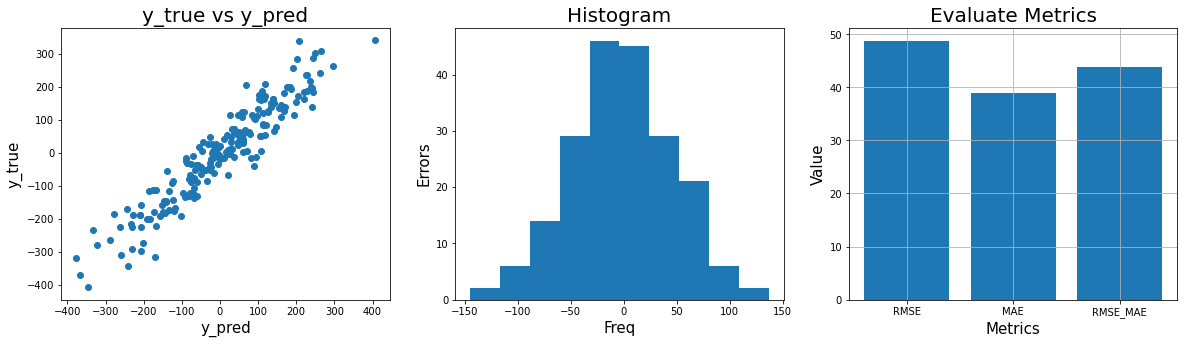

In [9]:
### EVALUATE MODEL EXAMPLE ENSEMBLE (using the functions auxiliar notebook 1)###
metrics_ex_ensemble = evaluate_metrics(model = ex_ensemble, 
                           X = X_test, 
                           y_true = y_test
                          )

evaluate_quality_models(model = ex_ensemble, 
                        X = X_test, 
                        y_true = y_test, 
                        df_metrics = metrics_ex_ensemble
                       )

### 3. Create Ensemble Model
- Create a function that return the ensemble model

- In this example are create 4 ensemble models, the first one has 3 base models, the second one has 4 base models , the third one has 5 models and the last one has 6 base models

In [10]:
def ensemble_model_3():
    # define the base models
    level0 = []
    level0.append(('knn', KNeighborsRegressor()))
    level0.append(('cart', DecisionTreeRegressor(random_state = 42)))
    level0.append(('svm', SVR()))

    # define meta learner model
    level1 = LinearRegression()

    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [11]:
def ensemble_model_4():
    # define the base models
    level0 = []
    level0.append(('knn', KNeighborsRegressor()))
    level0.append(('cart', DecisionTreeRegressor(random_state = 42)))
    level0.append(('svm', SVR()))
    level0.append(('rf', RandomForestRegressor(random_state = 42))) # append model

    # define meta learner model
    level1 = LinearRegression()

    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [12]:
def ensemble_model_5():
    # define the base models
    level0 = []
    level0.append(('knn', KNeighborsRegressor()))
    level0.append(('cart', DecisionTreeRegressor(random_state = 42)))
    level0.append(('svm', SVR()))
    level0.append(('rf', RandomForestRegressor(random_state = 42)))
    level0.append(('xgb', xgboost.XGBRegressor(random_state = 42))) # append model

    # define meta learner model
    level1 = LinearRegression()

    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [13]:
def ensemble_model_6():
    # define the base models
    level0 = []
    level0.append(('knn', KNeighborsRegressor()))
    level0.append(('cart', DecisionTreeRegressor(random_state = 42)))
    level0.append(('svm', SVR()))
    level0.append(('rf', RandomForestRegressor(random_state = 42)))
    level0.append(('xgb', xgboost.XGBRegressor(random_state = 42)))
    level0.append(('ltb', ltb.LGBMRegressor(random_state = 42))) # append model

    # define meta learner model
    level1 = LinearRegression()

    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

### 4.- Evaluate quality of the models (individuals and ensemble models) (cross validation)
- Evaluate the distributions of the METRICS of each model using repeated cross validation

- Evaluate the individuals models generated in the notebook and the ensemble models generated in the last step

In [14]:
# create a function that have ALL THE MODELS (individual and ensemble models)THAT WILL BE EVALUATED. 
# return a dictionary with these models

def get_models():
    '''
    Create a function that have ALL THE MODELS THAT WILL trained
    '''
    # create a dictionary where are saved the different models that will be trained
    models = dict()

    # complete dictionary with models
    models['lr'] = LinearRegression()
    models['cart'] = DecisionTreeRegressor(random_state = 42)
    models['rf'] = RandomForestRegressor(random_state = 42)
    models['knn'] = KNeighborsRegressor()
    models['svr'] = SVR()
    models['xgb'] = xgboost.XGBRegressor(random_state = 42)
    models['ltb'] = ltb.LGBMRegressor(random_state = 42)
    models['ensemble3'] = ensemble_model_3()
    models['ensemble4'] = ensemble_model_4()
    models['ensemble5'] = ensemble_model_5()
    models['ensemble6'] = ensemble_model_6()
    
    # return dictionary with the models
    return models

In [15]:
def evaluate_model(model, X, y):
    '''
    Given a model and a dataset train (X, y).
    Generate the splitter and then train the model with the differents folds and return the metrics getting in 
    the training of each folder
    '''
    # defining a CV SPLITTER (repeated K folds)
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    # getting the scores for each FOLD
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv)
    scores = -scores
    
    return scores

In [16]:
def evaluate_quality_of_models(X, y, dicc_models):
    '''
    Evaluate the quality of the models
    
    Given the dataframe of Train and a dictionary with all the models that will be evaluated using repated cross validation
    '''
    
    # initialize
    results_metrics_model, name_model = [], []


    # run
    for name, model in dicc_models.items():
        print('\nEvaluating... ', name)

        # get metrics of each model
        scores = evaluate_model(model, X, y)
        results_metrics_model.append(scores)
        name_model.append(name)

        #print
        print(f'Mean: {round(np.mean(scores), 3)} // std: {round(np.std(scores), 3)}')
        
    
    return results_metrics_model, name_model

In [17]:
models = get_models()

In [18]:
results_metrics_model, name_model = evaluate_quality_of_models(X = X_train, 
                                                               y = y_train, 
                                                               dicc_models = models)


Evaluating...  lr
Mean: 10.4 // std: 0.795

Evaluating...  cart
Mean: 84.835 // std: 7.893

Evaluating...  rf
Mean: 51.067 // std: 6.225

Evaluating...  knn
Mean: 100.349 // std: 6.581

Evaluating...  svr
Mean: 140.792 // std: 10.771

Evaluating...  xgb
Mean: 44.267 // std: 5.136

Evaluating...  ltb
Mean: 35.33 // std: 5.65

Evaluating...  ensemble3
Mean: 56.432 // std: 5.783

Evaluating...  ensemble4
Mean: 42.506 // std: 4.67

Evaluating...  ensemble5
Mean: 39.218 // std: 4.403

Evaluating...  ensemble6
Mean: 32.824 // std: 4.554


### 5. Make boxplot with the distribution of the metrics of each model

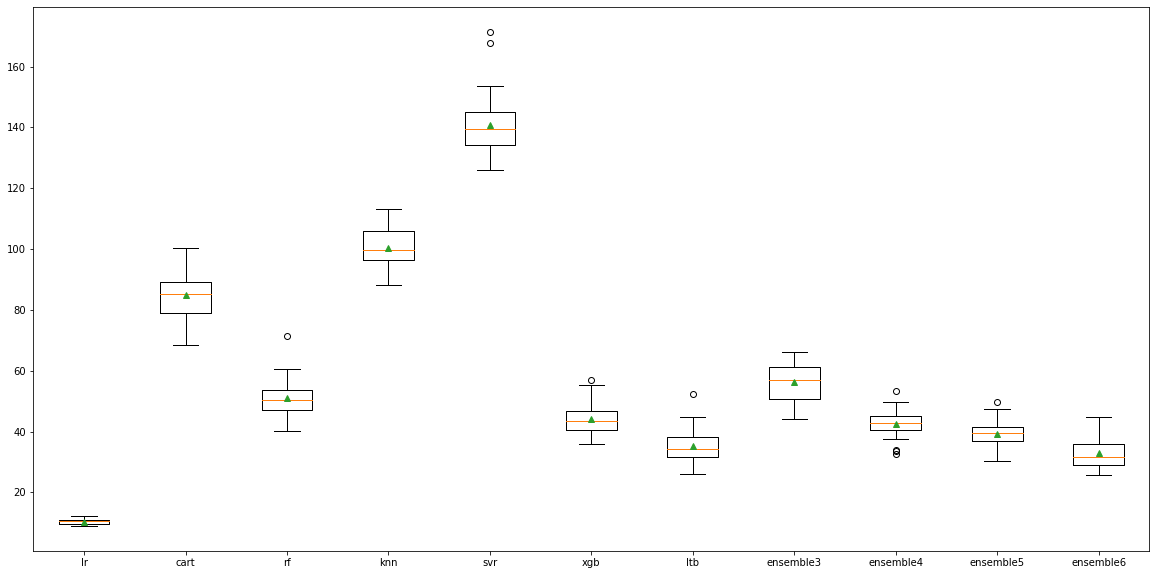

In [19]:
plt.figure(figsize = (20, 10))
plt.boxplot(results_metrics_model, labels = name_model, showmeans=True)
plt.savefig(fname = f'reports/results_{path_data_example_1}')
#plt.show()